# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Example of data exploration, modeling, regulartion and prediction
Our exercise today involves loading a standard dataset using TensorFlow Keras API, exploring the data, building a simple neural network, and evaluating the effects of basic methods (activation functions, regularization, weight initialization, etc.). We then perform predictions on the test set and inspect the results.

# 1. Data
The dataset we will use is the well-known CIFAR10 (Canadian Institute For Advanced Research). Explore the details on the Keras website first: https://keras.io/api/datasets/cifar10/

After you explored the basic features of the data, let's load it into the memory and explore the shapes:

In [12]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [13]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [14]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


## 1.1. Exercise
Display the first ten images of the training data. Hints:
* Axis 0 refers to the separate images, e.g. X_train[0]
* You can use the [Matplotlib Pyplot imshow function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) for displaying the image. Just don't forget to import Plotly first!
* A corresponding example, but you have to modify the code for your purpose: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly

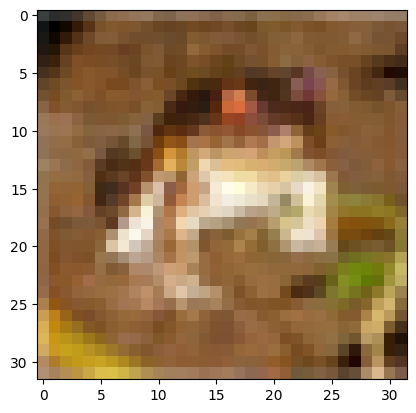

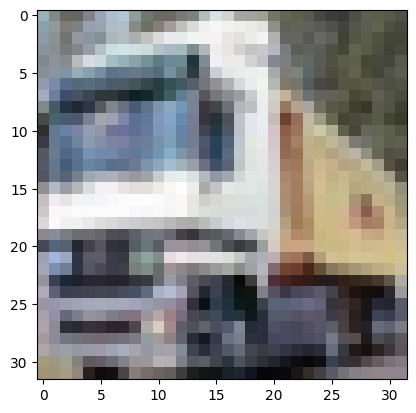

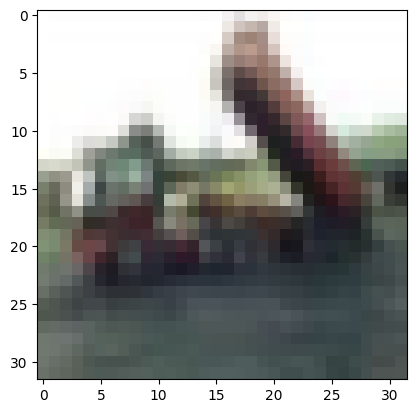

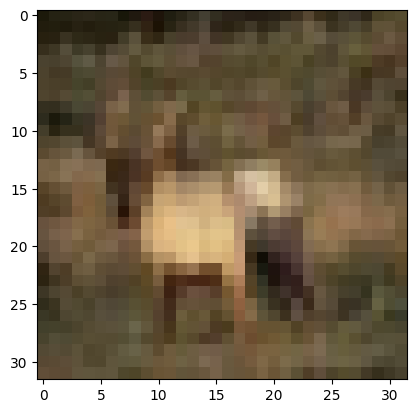

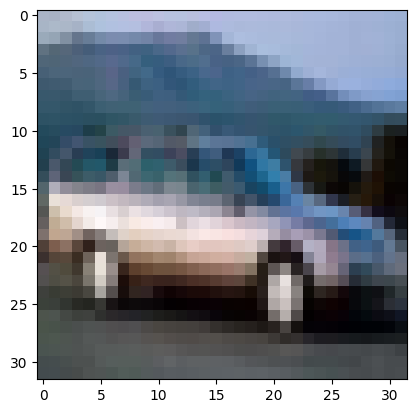

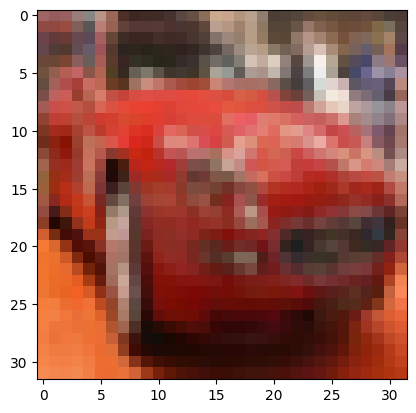

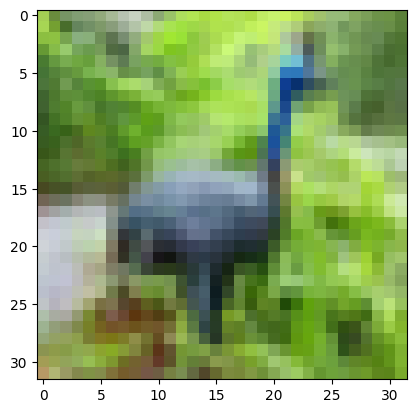

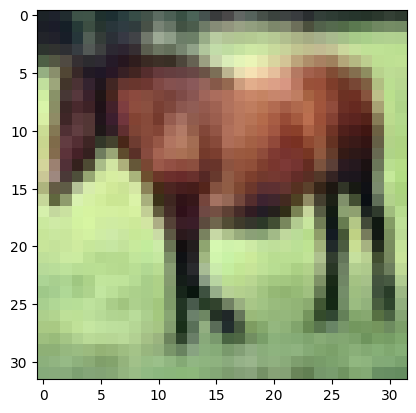

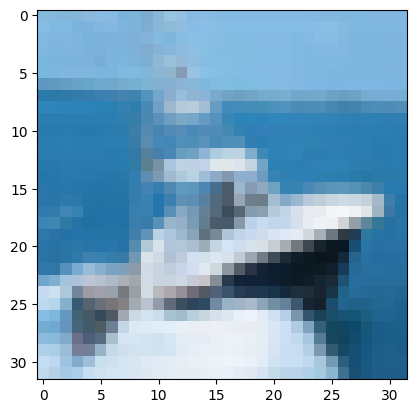

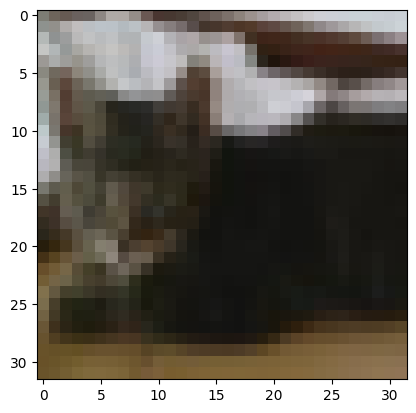

In [15]:
import matplotlib.pyplot as plt

for i in range (10):
  image = X_train[i]
  plt.imshow(image)
  plt.show()

Print the corresponding labels of the displayed images from the target variable (Y_train):

In [16]:
map = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

for i in range (10):
  label = Y_train[i]
  print(f"label for {i} is {label} and the object is {map[label[0]]}")

label for 0 is [6] and the object is frog
label for 1 is [9] and the object is truck
label for 2 is [9] and the object is truck
label for 3 is [4] and the object is deer
label for 4 is [1] and the object is automobile
label for 5 is [1] and the object is automobile
label for 6 is [2] and the object is bird
label for 7 is [7] and the object is horse
label for 8 is [8] and the object is ship
label for 9 is [3] and the object is cat


## 1.2. Exercise
We will train a Multi-Layer Perceptron (MLP), which requires a 2 dimensional input: 0th axis refers to the datapoints (i.e. images), the 1th dimens to the input. As images are 3 dimensional (width, height, color channels), you have to reshape the images into vectors. We also call this flattening.

In order to do so, calculate the size of the equivalent 1D vector of the image:

In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

flattened_dim = IMG_HEIGHT * IMG_WIDTH * IMG_CHANNELS
print(f"Flattened dimension: {flattened_dim}")

Flattened dimension: 3072


After you calculated it, we can reshape the images, and covert the integer arrays into float arrays -- which are needed for the neural networks as input. Hint:
* in the [reshape() function of Numpy](https://www.w3schools.com/python/numpy/numpy_array_reshape.asp) you can use -1 for one axis, to automatically calculate that value.

In [18]:
# reshape 3D tensors to 2D tensors
X_train = X_train.reshape(-1, flattened_dim)
X_test = X_test.reshape(-1, flattened_dim)

# it is in int8 format, the neural network requires float32
X_train = X_train.astype(float)
X_test = X_test.astype(float)

print(X_train.shape)
print(X_test.shape)

(50000, 3072)
(10000, 3072)


## 1.3. Exercise
As the next step, let's split the training data into training and validation data. 80% of the original training data should be the final training data, and 20% the validation.
You should use Numpy indexing to select the first 80% of X_train as final X_train, and the last 20% as X_valid. Hints:
* https://datascienceparichay.com/article/numpy-array-first-n-rows/
* https://datascienceparichay.com/article/numpy-array-last-n-rows/

In [19]:
train_ratio  = 0.8
train_length = X_train.shape[0] # length of the training data
train_split  =  int(0.8 * train_length)# where to split the training and validation data
X_valid, Y_valid = X_train[train_split: ], Y_train[train_split: ]
X_train, Y_train = X_train[:train_split], Y_train[:train_split]

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"Y_valid: {Y_valid.shape}")

X_train: (40000, 3072)
Y_train: (40000, 1)
X_valid: (10000, 3072)
Y_valid: (10000, 1)


## 1.4. Exercise
As the last step of input data preparation, the data should be standardized. Calculate the mean and variance of the training data (elementvise -- so for each value of the flattened image you should get a mean and variance for the training data along 0th axis). Hint:
* https://stackoverflow.com/questions/70626231/how-to-calculate-mean-variance-standard-deviation-per-index-of-array

In [20]:
mean = np.mean(X_train, axis = 0)
std  = np.std(X_train, axis = 0)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: [130.899125 136.1391   132.547525 ... 126.863725 126.03545  114.5743  ]
Standard deviation: [73.39898057 72.94089766 80.44087078 ... 65.06666431 62.78236053
 66.23705103]


Next, use the resulting values to standardize the training, validation and test data by substracting the mean and dividing the result with the standard deviation.

In [21]:
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test  - mean) / std

## 1.5. Exercise
And as the last step, convert the dense representation of the classes (i.e. 0,1,2,3...9) to one-hot encoding (0 = [1 0 0 0 0 0 0 0 0 0], 1 = [0 1 0 0 0 0 0 0 0 0] ... 9 = [0 0 0 0 0 0 0 0 0 1]). To do this, first, calculate the number of unique elements in the target training data. Hints:
* use the [unique() function](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) of Numpy to list the unique elements
* you can count the number of elements in a list with the [len() function](https://www.w3schools.com/python/ref_func_len.asp)

In [22]:
nb_classes = len(np.unique(Y_train))
print(nb_classes)

10


Doublecheck, if the same number of classes exists in the validation and test target data:

In [23]:
print("Validation data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_valid)))
print("Test data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_test)))

Validation data has the same number of classes, as the training data: True
Test data has the same number of classes, as the training data: True


And convert the dense representation into one-hot encoding. Hint:
* use the [to_categorical function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) with the calculated nb_classes


In [24]:
import tensorflow as tf

Y_train = tf.keras.utils.to_categorical(Y_train, nb_classes)
Y_valid = tf.keras.utils.to_categorical(Y_valid, nb_classes)
Y_test  = tf.keras.utils.to_categorical(Y_test, nb_classes)

## Final check of data preparation
Now, lets check the shapes and mean and standard deviation of the training, validation and test data.

In [25]:
print("Shapes of the training, validation and test input data:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes of the training, validation and test output data:", Y_train.shape, Y_valid.shape, Y_test.shape)
print("Mean values of the training, validation and test input data:", X_train.mean(), X_valid.mean(), X_test.mean())
print("Standard deviation of the training, validation and test input data:", X_train.std(), X_valid.std(), X_test.std())

Shapes of the training, validation and test input data: (40000, 3072) (10000, 3072) (10000, 3072)
Shapes of the training, validation and test output data: (40000, 10) (10000, 10) (10000, 10)
Mean values of the training, validation and test input data: 6.208922265216188e-18 0.0023437140466796656 0.013331171092908317
Standard deviation of the training, validation and test input data: 1.0000000000000009 0.9965601589924457 0.9978282721027735


Don't worry, if the mean and standard deviation of the validation and test data are not exactly 0 and 1, but these might be very mear to it (e.g. 0.01 mean, 0.99 variance).

# 2. Training

Let us begin with a simple example of creating a small neural network without regularization and training it with actual data. The purpose of this is to provide you with an example as to how to proceed with the next exercise.

In [26]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
# model definition
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flattened_dim,)))
model.add(Dense(128, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# training
network_history = model.fit(X_train, Y_train,
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,
                            epochs=40,
                            verbose=1)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3306 - loss: 1.9067 - val_accuracy: 0.3913 - val_loss: 1.7546
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4162 - loss: 1.6793 - val_accuracy: 0.4017 - val_loss: 1.7284
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4354 - loss: 1.6303 - val_accuracy: 0.4103 - val_loss: 1.7049
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4556 - loss: 1.5826 - val_accuracy: 0.4181 - val_loss: 1.6862
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4639 - loss: 1.5538 - val_accuracy: 0.4288 - val_loss: 1.6663
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4717 - loss: 1.5205 - val_accuracy: 0.4242 - val_loss: 1.6601
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4878 - loss: 1.4877 - val_accuracy: 0.4313 - val_loss: 1.6474
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4901 - loss: 1.4725 - val_accuracy: 0

Let's plot the training and validation loss and accuracy curves:

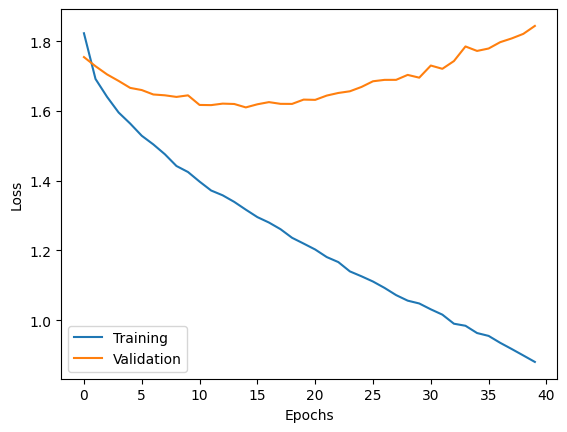

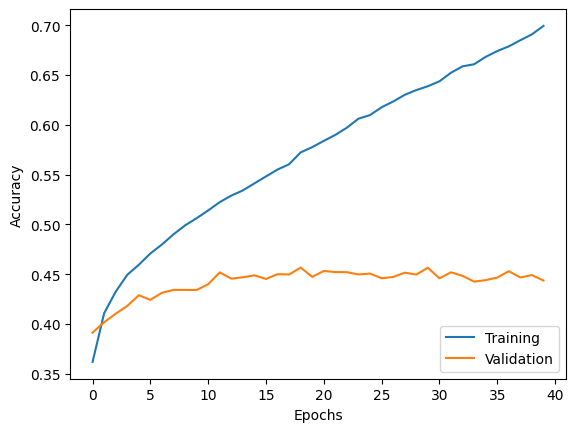

In [29]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

What do you think? Does it overfit?

# Inspecting the model

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,233,440 (4.71 MB)

 Trainable params: 411,146 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 822,294 (3.14 MB)

In [31]:
print('Input: ', model.input)

AttributeError: The layer sequential has never been called and thus has no defined input.

In [32]:
print('Layers:\n')
for layer in model.layers:
    print("Layer's name: ", layer.name, ', trainable: ', layer.trainable)
    print(layer.get_config(),'\n')

Layers:

Layer's name:  dense , trainable:  True
{'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 128, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} 

Layer's name:  dense_1 , trainable:  True
{'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 128, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': No

In [33]:
print('Output: ', model.output)

AttributeError: The layer sequential has never been called and thus has no defined output.

## 2.1. Exercise
Introduce [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) and [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) with a rate between 0.1..0.5. Tips:

* Insert the dropout layer between the two Dense layers.
* Set the patience of early stopping to 5.
* Set the number of epochs to a very high number.
* Don't forget to restore best weights after early stopping.
* And also set early stopping to monitor validation accuracy (the default value is validation loss -- which is categorical crossentropy now).

Compile and train the model. Attempt to increase the validation accuracy as much as possible by making changes to the dropout rate. Inspect the effects of the modifications.

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True,
    monitor = 'val_accuracy',
)
dropout = tf.keras.layers.Dropout(0.3)

In [35]:
# model definition with dropout
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(flattened_dim,)))

model.add(dropout)

model.add(Dense(128, activation='tanh'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# training with early stopping
network_history = model.fit(X_train, Y_train,
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,
                            epochs=1000,
                            verbose=1,
                            callbacks=[es])

Epoch 1/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2965 - loss: 1.9969 - val_accuracy: 0.3789 - val_loss: 1.7743
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3691 - loss: 1.7933 - val_accuracy: 0.3953 - val_loss: 1.7434
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3863 - loss: 1.7482 - val_accuracy: 0.4042 - val_loss: 1.7110
Epoch 4/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3973 - loss: 1.7187 - val_accuracy: 0.4157 - val_loss: 1.6903
Epoch 5/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4172 - loss: 1.6730 - val_accuracy: 0.4151 - val_loss: 1.6794
Epoch 6/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4213 - loss: 1.6654 - val_accuracy: 0.4235 - val_loss: 1.6599
Epoch 7/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4365 - loss: 1.6281 - val_accuracy: 0.4302 - val_loss: 1.6376
Epoch 8/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4368 - loss: 1.6176 -

## 2.2 Exercise
Change the [activation function of the dense layers (except the last one)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) to rectified linear unit (ReLU) and the [weight initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) to the theoretically best one. Use the original model's code.

Compile and train the model. Inspect the effects of the modifications.

In [64]:
# model definition with relu
model = Sequential()
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_shape=(flattened_dim,)))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# training
network_history = model.fit(X_train, Y_train,
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,
                            epochs=40,
                            verbose=1)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3338 - loss: 2.0149 - val_accuracy: 0.4286 - val_loss: 1.6658
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4658 - loss: 1.5235 - val_accuracy: 0.4559 - val_loss: 1.5762
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5060 - loss: 1.4045 - val_accuracy: 0.4619 - val_loss: 1.5458
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5359 - loss: 1.3186 - val_accuracy: 0.4820 - val_loss: 1.4965
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5583 - loss: 1.2489 - val_accuracy: 0.4913 - val_loss: 1.4913
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5835 - loss: 1.1832 - val_accuracy: 0.4851 - val_loss: 1.5256
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6000 - loss: 1.1312 - val_accuracy: 0.5006 - val_loss: 1.5154
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6177 - loss: 1.0849 - val_accuracy: 0

# 2.3. Exercise
Based on the modifications above, and by any further modifications (e.g. more layers, less layers, more neurons/layer, etc.) to the model design, find a combination that is able to achieve **validation accuracy, that is higher than 53%**.


In [91]:
es = tf.keras.callbacks.EarlyStopping(
    patience = 15,
    restore_best_weights = True,
    monitor = 'val_accuracy',
)
dropout = tf.keras.layers.Dropout(0.2)

In [92]:
# model definition
model = Sequential()
model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform', input_shape = (flattened_dim, )))
model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform'))

model.add(dropout)

model.add(Dense(512, activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dense(nb_classes, activation='softmax'))

# loss function and optimizer
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [93]:
# training
network_history = model.fit(
    X_train, Y_train,
    validation_data = (X_valid, Y_valid),
    batch_size = 128,
    epochs = 200,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3076 - loss: 2.1588 - val_accuracy: 0.4058 - val_loss: 1.6551
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4196 - loss: 1.6472 - val_accuracy: 0.4442 - val_loss: 1.5668
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4669 - loss: 1.5157 - val_accuracy: 0.4682 - val_loss: 1.5020
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4941 - loss: 1.4262 - val_accuracy: 0.4791 - val_loss: 1.4699
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5201 - loss: 1.3482 - val_accuracy: 0.4931 - val_loss: 1.4488
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5408 - loss: 1.2791 - val_accuracy: 0.4934 - val_loss: 1.4377
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5620 - loss: 1.2343 - val_accuracy: 0.5107 - val_loss: 1.4109
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5758 - loss: 1.1758 - val_acc

# 3. Evaluation on test data and inference
At this point, we will perform a basic evaluation and inference. With the model.evaluate function, the same metrics are calculated, that were used during training:

In [94]:
print(model.evaluate(X_test, Y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5383 - loss: 2.0465
[2.1074492931365967, 0.5295000076293945]


we would like to see similar values, as in the validation set. If those are close to each other, then the generalization ability of the model is good (in case of an independent test-set).

## 3.1. Exercise
Predict the class of the first 10 elements in the test set, and compare the predicted values with the actual, target values in the test set. Hints:
* you can use [model.predict](https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/) for prediction
* from the output you can select the largest value with the [argmax() function of Numpy](https://stackoverflow.com/questions/62358642/convert-one-hot-encoding-back-to-number-label). As there are multiple values, you have to call it with axis=1 parameter.
* it is enought to compare the predictions and the targets by printing the values out and inspecting them.

In [95]:
preds = model.predict(X_test[:10])
preds_dense = np.argmax(preds, axis=1)

print(preds)
print(preds_dense)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
[[6.2551364e-05 2.4839912e-05 7.4394459e-01 1.8446285e-01 6.6304177e-02
  2.9729544e-03 1.7278846e-03 2.4771536e-04 1.6561088e-04 8.6900800e-05]
 [9.1647235e-05 1.2833861e-02 1.1048010e-06 8.1614400e-07 3.4204584e-07
  1.3685244e-09 8.0737401e-08 1.2111933e-08 9.8671639e-01 3.5573330e-04]
 [9.6917778e-01 2.7076053e-03 2.7161035e-05 4.6742553e-05 5.8764399e-06
  2.2687251e-05 5.6713446e-07 2.0560378e-02 1.2274804e-04 7.3284633e-03]
 [8.3253646e-01 4.8913732e-03 1.8846462e-04 3.0612483e-04 9.2247457e-05
  3.2135329e-05 1.6448508e-06 1.3334410e-03 1.5975045e-01 8.6763361e-04]
 [5.3410931e-10 1.7357106e-09 2.3137811e-05 9.6216863e-05 2.1557631e-03
  2.3118975e-05 9.9770170e-01 8.1049961e-08 6.2363985e-09 1.4072890e-10]
 [3.5269131e-05 1.1090783e-05 5.5957919e-01 3.3484721e-03 6.8148761e-03
  3.1216431e-03 4.2684796e-01 2.1879011e-04 9.4247689e-06 1.3264971e-05]
 [2.0191724e-04 1.0166501e-02 2.3163332e-01 7.0390308e-01 3.7803024e-02
  4.1730157e-03 1.1

Before comparision, you have to convert back the one-hot encoded target values the same way, as you converted the output of the neural network to class values with argmax() function.

In [96]:
print("Target labels:", np.argmax(Y_test[:10],axis=1))
print("Predicted labels:", preds_dense)

print("Target labels:", [map[label] for label in np.argmax(Y_test[:10], axis=1)])
print("Predicted labels:", [map[label] for label in preds_dense])

Target labels: [3 8 8 0 6 6 1 6 3 1]
Predicted labels: [2 8 0 0 6 2 3 6 4 1]
Target labels: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']
Predicted labels: ['bird', 'ship', 'airplane', 'airplane', 'frog', 'bird', 'cat', 'frog', 'deer', 'automobile']
